<a href="https://colab.research.google.com/github/juan-ivan-NV/Btc_trading/blob/master/Data_extraction_and_models_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series for cryptocurrencies (daily data)

![texto alternativo](https://worldview.stratfor.com/sites/default/files/styles/article_full/public/cryptocurrency-gulf-display-shutterstock-1028639176.png?itok=K36RQG5A.jpg)

## Extracting (web scraping) daily data from top 200 cryptocurrencies available at  https://coinmarketcap.com/coins/ but also you can find more datasets with data by hour at https://www.cryptodatadownload.com/data/

First of all is important to run all libraries to solve possible issues first and avoid the environment restarting 

### Libraries

In [1]:
# ► First libs

import matplotlib.pyplot as plt
import plotly.express as px 
import pandas as pd
import numpy as np
import re

# ► More libs for the extraction function

import datetime 
import csv

In [3]:
# ► For PyCaret model (Regression models)

!pip install pycaret==2.0
#from pycaret.regression import *  # we will rin this line in next sections

In [4]:
# ► For prophet model (Time series)

import fbprophet
import matplotlib.pyplot as plt

In [5]:
# ► For arima model (Time series)

#!pip install pmdarima
from pmdarima.arima import auto_arima
from scipy import stats
from itertools import product
import warnings
import statsmodels.api as sm

In [6]:
# ► libraries for LSTM and GRU RNN's

# To flat a list of lists
from pandas.core.common import flatten
# Scale Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler                
# Indicator
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
# Model Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense, GRU, LSTM, Dropout, Bidirectional
from keras.optimizers import SGD

### Scraping first table

In [7]:
# ► Scraping main table wit pandas

url = 'https://coinmarketcap.com/coins/views/all/'
df = pd.read_html(url)[2]
df.head()

,Rank,Name,Symbol,Market Cap,Price,Circulating Supply,Volume (24h),% 1h,% 24h,% 7d,Unnamed: 10
0,1,Bitcoin,BTC,"$193,672,877,883","$10,470.83","18,496,418 BTC","$30,392,655,398",0.30%,-4.52%,-1.99%,NaN
1,2,Ethereum,ETH,"$38,900,053,396",$345.16,"112,700,347 ETH","$17,841,850,712",1.22%,-8.11%,-8.50%,NaN
2,3,XRP,XRP,"$10,473,007,930",$0.232231,"45,097,364,449 XRP *","$2,346,650,930",0.22%,-5.96%,-5.68%,NaN
3,4,Bitcoin Cash,BCH,"$3,956,537,942",$213.59,"18,524,175 BCH","$1,990,467,079",0.27%,-6.58%,-5.60%,NaN
4,5,Polkadot,DOT,"$3,499,784,101",$4.10,"852,647,705 DOT *","$1,211,036,870",0.72%,-11.83%,-23.56%,NaN


In [8]:
# ► Getting rid of '$,' simbols

df.Price = df['Price'].apply(lambda x: float(re.sub('([$,]*)','',x)))
df.sort_values(by=['Price'], inplace=True, ascending=False)

In [9]:
# ► Below Bitcoin is omitted because its price is too high to appreciate the rest of the coins

fig = px.bar(df[1:], y='Price', x='Name', text='Name')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(template='seaborn', title='Coins available for scraping')
fig.show()

In [10]:
coins_available = list(df.Name)

In [11]:
# ► Repacing ' ' and '.' for '-' and deleting '[]#'  

coins_available = [re.sub('([\s+.])','-',coin.lower()).replace('[','').replace(']','').replace('#','') for coin in coins_available]

In [12]:
print(coins_available)

['bitcoin', 'ethereum', 'bitcoin-cash', 'bitcoin-sv', 'monero', 'unobtanium', 'bitcoinpos', 'dash', 'zcash', 'bonorum', 'litecoin', 'kusama', 'binance-coin', 'obyte', 'counos-x', 'neo', 'salus', 'decred', 'largo-coin', 'energy-web-token', 'elrond', 'newyork-exchange', 'bitcoin-gold', 'counos-coin', 'horizen', 'ethereum-classic', 'cosmos', 'polkadot', 'zcoin', 'bitcoinhd', 'mimblewimblecoin', 'arweave', 'chainx', 'solana', 'celo', 'ghostprism', 'vitae', 'eos', 'platincoin', 'qtum', 'waves', 'zenon', 'haven-protocol', 'tezos', 'clams', 'serum', 'elastos', 'helium', 'cryptonex', 'energi', 'factom', 'monacoin', 'lisk', 'hypercash', 'zynecoin', 'blocknet', 'tomochain', 'nano', 'ergo', 'deviantcoin', 'ontology', 'dero', 'creditcoin', 'bhpcoin', 'komodo', 'theta', 'loki', 'bitcoin-diamond', 'skycoin', 'gxchain', 'ghost', 'aidos-kuneen', 'darma-cash', 'neblio', 'icon', 'stratis', 'bitcoin-2', 'insolar', 'fusion', 'xenioscoin', 'pivx', 'baer-chain', 'nebulas', 'grin', 'hellenic-coin', 'safe', '

## Function to obtain some coins data like 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'.



In [13]:
# ► Function to extract data

def get_data(coins_available):
 
  # ► User types a number

  print(coins_available)
  coin_name = input('Type a valid coin name: ').lower()

  while True:

    if coin_name not in coins_available:
      print('Coin name should not contain spaces instead use "-" and type all in lowercase')
      coin_name = input('Type again a valid coin name: ').lower()
    else:
      break
  
  # ► Scrapping the coin name

  today = datetime.date.today()  # todays date
  mktcap_page = 'https://coinmarketcap.com/currencies/'+ coin_name +'/historical-data/?start=20130428&amp;end='+"{:%Y%m%d}".format(today)
  full_data = pd.read_html(mktcap_page)[2]
  full_data.rename(columns={'Open*': 'Open', 'Close**': 'Close'}, inplace=True)

  # ► This function replaces ',' for nothing and then changes data type from object to float

  def obj_to_num(df,cols):
      
      def obj_to_num(row):
          if ',' in str(row):
            row = row.replace(',','')
            return float(row)
          else:
            return float(row)

      for col in cols:     
          df[col] = df[col].apply(obj_to_num) 

      return df

  # ► This function changes data column type from object to timestamp[ns] and also can changes other columns to float 

  def prepare_data(file):
  
    columns = ['Open','High','Low','Close','Volume','Market Cap']
    file['Date'] = pd.to_datetime(file['Date'])
    num_data = obj_to_num(file,columns)

    return num_data

  return prepare_data(full_data)


## Coin exploration (Ethereum in this case)

You can type any coin (available in the list) to be analized

In [14]:
# ► Type the coin name you want

my_coin = get_data(coins_available)

['bitcoin', 'ethereum', 'bitcoin-cash', 'bitcoin-sv', 'monero', 'unobtanium', 'bitcoinpos', 'dash', 'zcash', 'bonorum', 'litecoin', 'kusama', 'binance-coin', 'obyte', 'counos-x', 'neo', 'salus', 'decred', 'largo-coin', 'energy-web-token', 'elrond', 'newyork-exchange', 'bitcoin-gold', 'counos-coin', 'horizen', 'ethereum-classic', 'cosmos', 'polkadot', 'zcoin', 'bitcoinhd', 'mimblewimblecoin', 'arweave', 'chainx', 'solana', 'celo', 'ghostprism', 'vitae', 'eos', 'platincoin', 'qtum', 'waves', 'zenon', 'haven-protocol', 'tezos', 'clams', 'serum', 'elastos', 'helium', 'cryptonex', 'energi', 'factom', 'monacoin', 'lisk', 'hypercash', 'zynecoin', 'blocknet', 'tomochain', 'nano', 'ergo', 'deviantcoin', 'ontology', 'dero', 'creditcoin', 'bhpcoin', 'komodo', 'theta', 'loki', 'bitcoin-diamond', 'skycoin', 'gxchain', 'ghost', 'aidos-kuneen', 'darma-cash', 'neblio', 'icon', 'stratis', 'bitcoin-2', 'insolar', 'fusion', 'xenioscoin', 'pivx', 'baer-chain', 'nebulas', 'grin', 'hellenic-coin', 'safe', '

In [15]:
# ► df visualization

my_coin.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2020-09-21,371.40,375.74,336.07,341.79,1.739827e+10,3.851937e+10
1,2020-09-20,385.60,385.60,367.09,371.05,1.229220e+10,4.181264e+10
2,2020-09-19,384.04,387.08,378.72,385.54,1.104951e+10,4.344036e+10
3,2020-09-18,389.34,391.90,376.96,384.36,1.410836e+10,4.330219e+10
4,2020-09-17,365.87,393.90,364.80,389.02,1.989953e+10,4.382135e+10


In [16]:
my_coin.dtypes

Date          datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume               float64
Market Cap           float64
dtype: object

In [17]:
# ► The graph

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Open'],
                    mode='lines',
                    name='Open'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['High'],
                    mode='lines',
                    name='High'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Low'],
                    mode='lines',
                    name='Low'))
fig.add_trace(go.Scatter(x=my_coin['Date'], y=my_coin['Close'],
                    mode='lines',
                    name='Close'))

#fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title="Coin behavior from its beginning, price in USD")

fig.show()

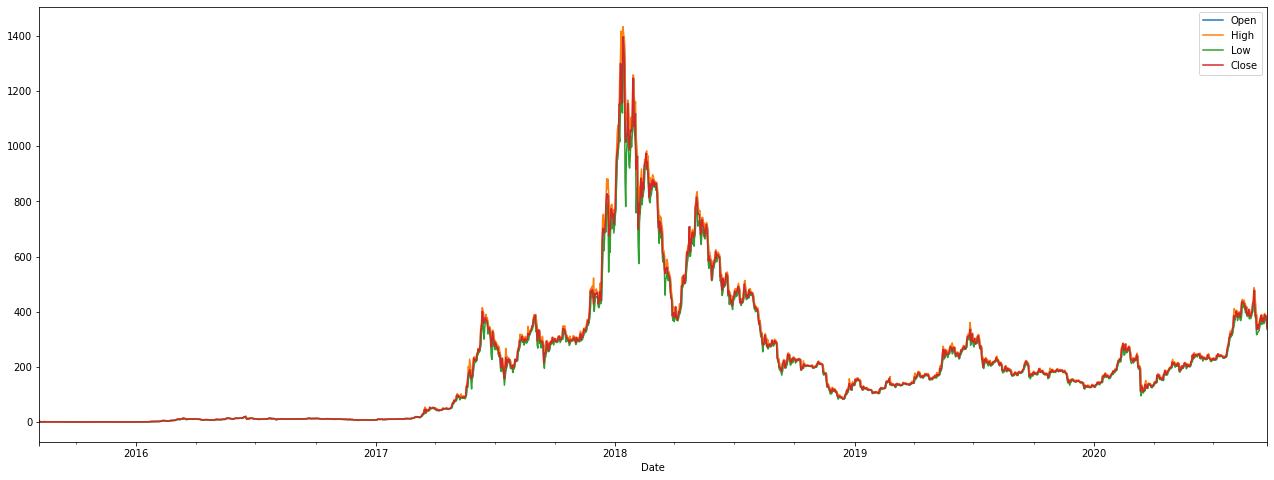

In [18]:
my_coin_graph = my_coin.set_index('Date') 
_ = my_coin_graph[['Open','High','Low','Close']].plot(figsize=(22, 8))

In [19]:
# ► Saving data to csv
my_coin.to_csv('my_coin_daily_data.csv')

# Models

In [20]:
# ► Changing the order of the df 

my_coin = my_coin.copy()[::-1]

In [21]:
# ► Data for training till last 20 samples

my_coin_high_train = my_coin[['High','Date']][:-20]

In [22]:
# ► Data for testing 20 samples

my_coin_high_test = my_coin[['High','Date']][-20:]

### FbProphet

In [23]:
# ► Renaming columns for Prophet

my_coin_high_p = my_coin_high_train.rename(columns = {'Date':'ds','High':'y'})

In [24]:
# ► setting this hyperparameter to 0.8  https://facebook.github.io/prophet/docs/trend_changepoints.html#adjusting-trend-flexibility
# ► 1.1 = mse(2805.25), 0.8 = mse(2857.13), 1.2 = mse(3015.23), 0.75 = mse(3038.22), 0.9 = mse(3039.19), 0.5 = mse(3182.94)   

m = fbprophet.Prophet(changepoint_prior_scale=1.1)

In [25]:
m.fit(my_coin_high_p)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
# ► Generating future 20 dates

future = m.make_future_dataframe(periods=20)

In [27]:
# ► Predicting those days

forecast_p = m.predict(future)

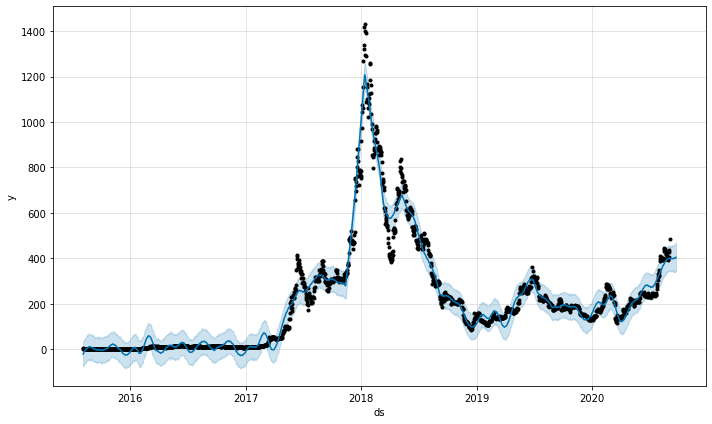

In [28]:
m.plot(forecast_p);

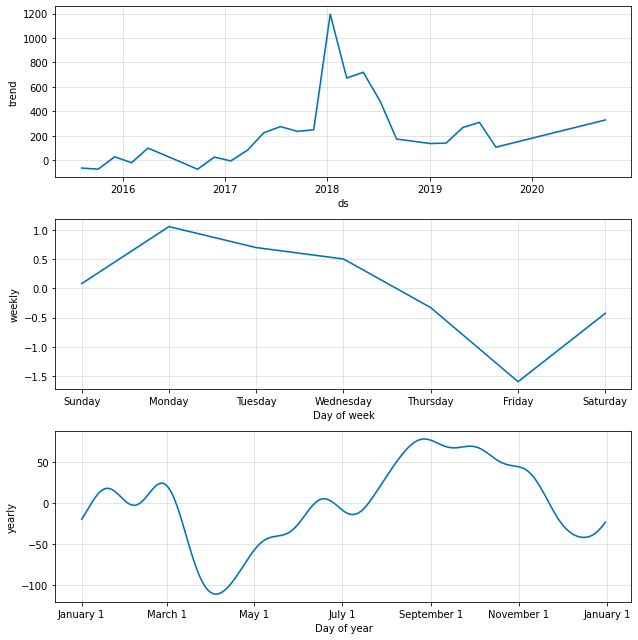

In [28]:
m.plot_components(forecast_p);

In [29]:
# ► predictions and real data

my_coin_inverse = my_coin.copy() 
my_coin_inverse.High = my_coin_inverse.High.values[::-1]                        # To change value orders from the original data
my_coin_forecast = pd.concat([forecast_p['ds'],my_coin_inverse['High'],forecast_p['yhat']], axis=1,keys=['date','high','prophet_high'])

In [30]:
# ► The model didn't see this high values

my_coin_forecast.tail()

,date,high,prophet_high
1868,2020-09-17,393.90,400.576202
1869,2020-09-18,391.90,399.824135
1870,2020-09-19,387.08,401.649589
1871,2020-09-20,385.60,402.891532
1872,2020-09-21,375.74,404.669521


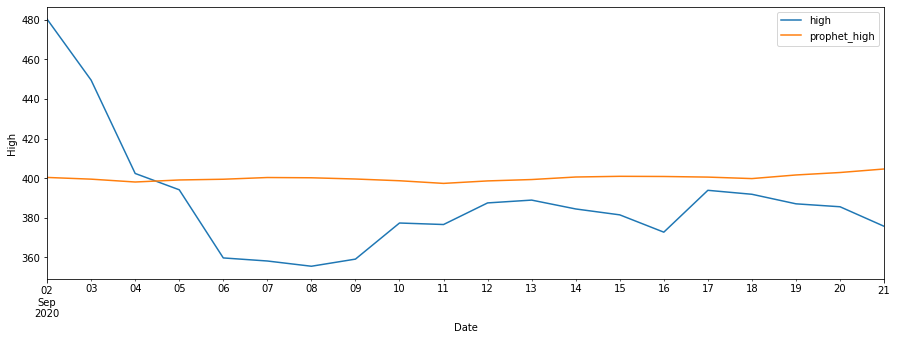

In [31]:
# ► Plot las 20 predictions and samples

ax = my_coin_forecast.set_index('date')[-20:].plot(figsize=(15, 5))
ax.set_ylabel('High')
ax.set_xlabel('Date')

plt.show()

### Arima

In [32]:
# ► Create a copy with values in reverse

my_coin_high_a = (my_coin[['Date','High']][:-20].copy()).set_index('Date')

In [33]:
my_coin_high_a.tail()

,High
Date,
2020-08-28,397.76
2020-08-29,405.62
2020-08-30,428.66
2020-08-31,438.56
2020-09-01,487.21


In [34]:
# Arima tunning hyperparameters
# Initial approximation of parameters

Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(my_coin_high_a.High, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [35]:
forecast_arima = pd.DataFrame(best_model.predict(start=0, end=len(my_coin_forecast)-1))

In [36]:
forecast_arima = forecast_arima.rename(columns = {0:'arima_high'})

In [37]:
# ► Joining data frames

my_coin_forecast_cp = pd.concat([my_coin_forecast.set_index('date'),forecast_arima], axis = 1, sort = False)

In [38]:
# ► Comparing 10 unseen data by both models

my_coin_forecast_cp.tail()

,high,prophet_high,arima_high
2020-09-16,372.77,394.987019,447.361433
2020-09-17,393.90,394.718247,447.021515
2020-09-18,391.90,394.099266,447.955595
2020-09-19,387.08,395.992921,447.398623
2020-09-20,385.60,397.280389,447.179204


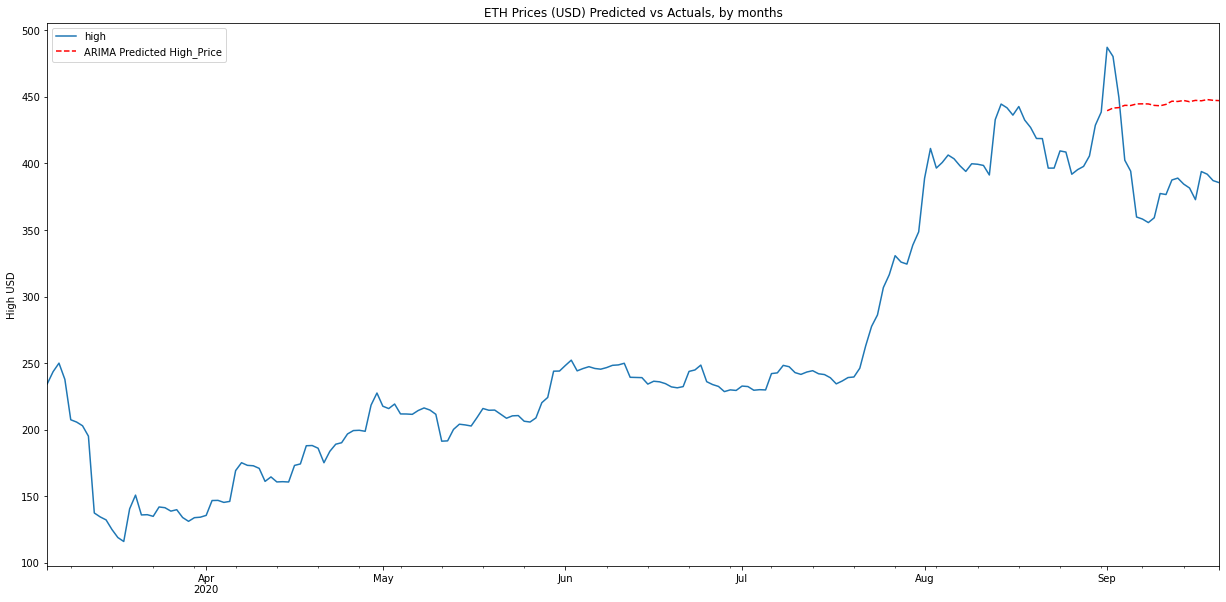

In [39]:
plt.figure(figsize=(21,10))
my_coin_forecast_cp.high[-200:].plot()
my_coin_forecast_cp.arima_high[-20:].plot(color='r', ls='--', label='ARIMA Predicted High_Price')
plt.legend()
plt.title('ETH Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('High USD')
plt.show()

### XGBoost

In [44]:
# ► Libraries for xgboost

import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [45]:
# ► Function to bring more dates info to the xgboost model

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.Date
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [46]:
# ► Creating data for training and testing 

X_train, y_train = create_features(my_coin_high_train, label='High')
X_test, y_test = create_features(my_coin_high_test, label='High')

In [47]:
# ► XGBoost model and hyperparameters

model =  xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=10, booster='gbtree', colsample_bytree = 0.8, learning_rate = 0.4,
                max_depth = 4, alpha = 10, n_estimators = 80)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.4, max_delta_step=0,
             max_depth=4, min_child_weight=10, missing=None, n_estimators=80,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [48]:
# ► Forecasting values

xgb_preds = model.predict(X_test)

In [49]:
# ► Data frame with dates as index

xgb_preds_df = (pd.DataFrame({'Date':my_coin_high_test.Date.values, 'xgb_forec':xgb_preds})).set_index('Date')

In [50]:
# ► Joining to the rest of predictions 

my_coin_forecast_cp = pd.concat([my_coin_forecast_cp,xgb_preds_df], axis = 1, sort = False)

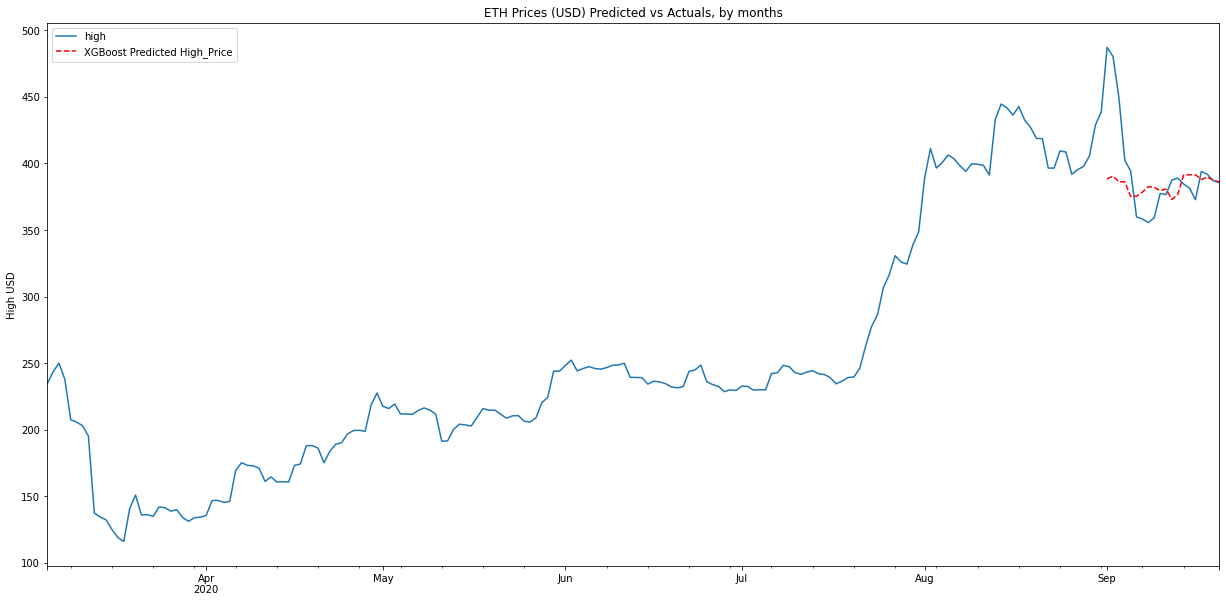

In [51]:
plt.figure(figsize=(21,10))
my_coin_forecast_cp.high[-200:].plot()
my_coin_forecast_cp.xgb_forec[-20:].plot(color='r', ls='--', label='XGBoost Predicted High_Price')
plt.legend()
plt.title('ETH Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('High USD')
plt.show()

### PyCaret

In [40]:
# ► To use regression models

from pycaret.regression import *

In [ ]:
#import pandas as pd
#my_coin = pd.read_csv('my_coin_daily_data.csv')
#my_coin['Date'] = pd.to_datetime(my_coin['Date'])

In [53]:
my_coin_high_py = my_coin_forecast_cp.reset_index()

In [54]:
my_coin_high_py = my_coin_high_py[['index','high']][:-20]
my_coin_high_py.tail()

,index,high
1847,2020-08-27,395.35
1848,2020-08-28,397.76
1849,2020-08-29,405.62
1850,2020-08-30,428.66
1851,2020-08-31,438.56


In [55]:
exp_reg = setup(data = my_coin_high_py, target = 'high')

 
Setup Succesfully Completed.


,Description,Value
0,session_id,4597
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(1852, 2)"
4,Missing Values,False
5,Numeric Features,0
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 0
INFO:logs:setup() succesfully completed......................................


In [56]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Lasso Regression,175.7145,58102.9681,239.7743,0.0183,2.0495,22.9708,0.0134
1,Bayesian Ridge,175.3448,58539.6271,240.6193,0.0120,2.0550,23.3969,0.0163
2,TheilSen Regressor,170.7002,58946.8655,241.2405,0.0086,2.0173,21.3666,2.2325
3,Ridge Regression,178.1518,58785.7198,241.2721,0.0049,2.0471,22.4485,0.0126
4,Least Angle Regression,178.2444,58812.5603,241.3335,0.0043,2.0470,22.4264,0.0199
5,Elastic Net,173.4075,59328.0394,242.0510,0.0021,2.0678,25.2693,0.0144
6,Linear Regression,179.3230,59002.8990,241.7464,0.0005,2.0508,22.5497,0.0139
7,Lasso Least Angle Regression,174.2131,59838.4741,243.0836,-0.0064,2.0707,25.6996,0.0128
8,Orthogonal Matching Pursuit,179.6349,60395.9764,244.5225,-0.0218,2.0740,25.1740,0.0135
9,Support Vector Machine,165.6977,61678.1943,246.5619,-0.0338,1.9707,20.4198,0.1433


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=4597,
      selection='cyclic', tol=0.0001, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [57]:
# ► Creating an ensemble meta-estimator that fits a base regressor on the whole dataset

blender_top3 = blend_models(compare_models(n_select = 3))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,161.9161,44888.9248,211.8701,-0.0044,2.0446,23.9236
1,181.4741,58284.8464,241.4225,0.0346,2.3367,31.4275
2,168.1528,49433.0091,222.3354,-0.0356,1.8981,19.4120
3,146.3025,37104.8331,192.6261,-0.0034,1.8587,17.8121
4,176.3694,57646.8687,240.0976,0.0516,2.0841,22.8329
5,183.6418,63090.1641,251.1776,0.0080,2.0729,23.9963
6,187.7213,83978.8931,289.7911,0.0154,1.9175,20.4319
7,179.0968,62436.7007,249.8734,0.0263,1.9874,19.6636
8,171.8499,56885.1152,238.5060,0.0502,2.0654,21.0995
9,181.5603,70314.7263,265.1692,0.0091,2.1419,25.1758


INFO:logs:create_model_container: 5
INFO:logs:master_model_container: 5
INFO:logs:display_container: 7
INFO:logs:VotingRegressor(estimators=[('Lasso_0',
                             Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=1000, normalize=False,
                                   positive=False, precompute=False,
                                   random_state=4597, selection='cyclic',
                                   tol=0.0001, warm_start=False)),
                            ('Bayesian Ridge_1',
                             BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=True,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=

In [58]:
# ► It does not plot Hyperparams cause is blended model  

evaluate_model(blender_top3)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [59]:
# ► Stage of predictions taking only dates

datat = pd.DataFrame(my_coin_forecast_cp.index).rename(columns={0: "index"})
lr_pred_new = predict_model(blender_top3, data = datat)

In [60]:
my_coin_forecast_cp['pycaret_high'] = lr_pred_new['Label'].values

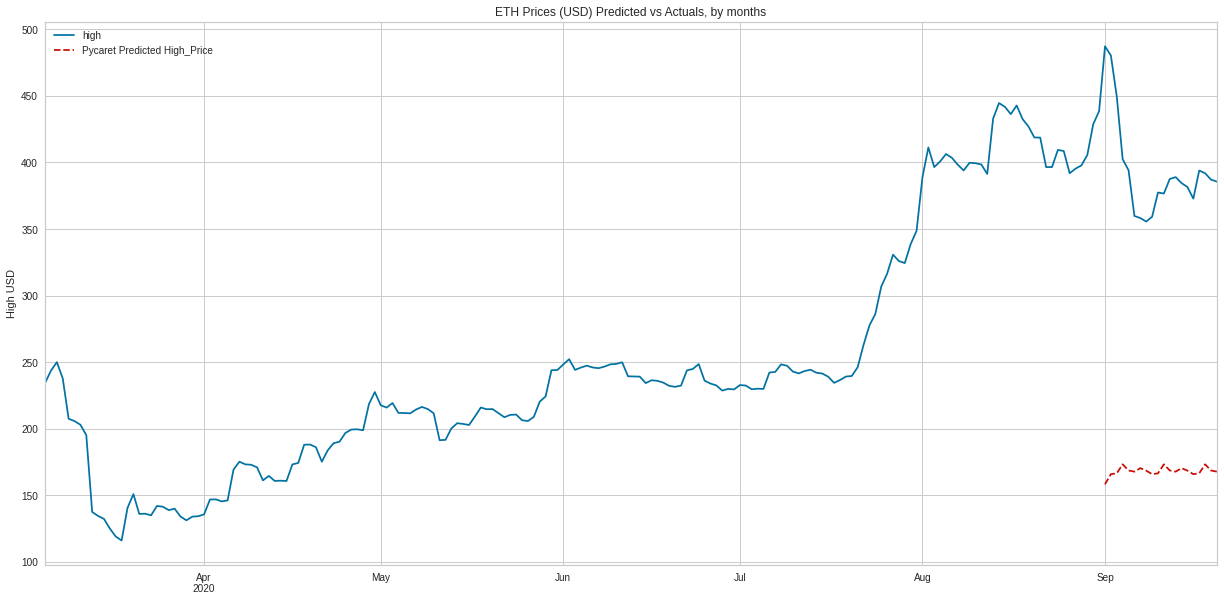

In [62]:
plt.figure(figsize=(21,10))
my_coin_forecast_cp.high[-200:].plot()
my_coin_forecast_cp.pycaret_high[-20:].plot(color='r', ls='--', label='Pycaret Predicted High_Price')
plt.legend()
plt.title('ETH Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('High USD')
plt.show()

### LSTM (Long Short Term Memory)

"Trying to kill a fly with a gun"

It's a little bit complicated to understand the code below but it works, I've been looking for a LSTM with keras but most of them are used incorrectly

Some information to understand RNN's https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [ ]:
# ► import mpl_finance interesting package

In [64]:
# ► Loading Data and changing the order

df = pd.read_csv('my_coin_daily_data.csv', index_col='Date', parse_dates = ['Date'])
df = df[::-1]
df.head()

,Unnamed: 0,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2015-08-07,1871,2.830000,3.540000,2.520000,2.770000,164329.0,166610555.0
2015-08-08,1870,2.790000,2.800000,0.714725,0.753325,674188.0,45486894.0
2015-08-09,1869,0.706136,0.879810,0.629191,0.701897,532170.0,42399573.0
2015-08-10,1868,0.713989,0.729854,0.636546,0.708448,405283.0,42818364.0
2015-08-11,1867,0.708087,1.130000,0.663235,1.070000,1463100.0,64569288.0


In [65]:
dflstm = df['High']

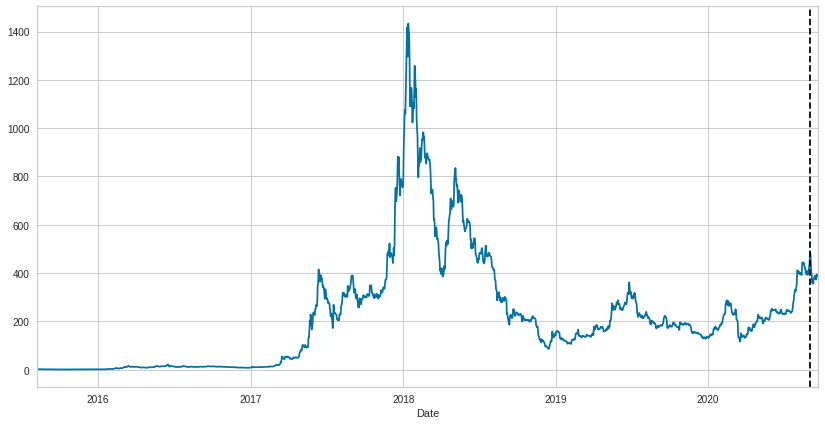

In [66]:
# Splitting data graph 20 samples to test

ax = dflstm.plot(figsize=(14, 7))
ax.axvline(dflstm.index[-20], linestyle="--", c="black")

In [67]:
# Scaling all data

scaler = MinMaxScaler(feature_range=(-1,1))
sc_lstm = scaler.fit_transform(dflstm.reset_index().drop(['Date'], 1))

In [69]:
def split_data(stock, lookback):
    
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = 20 
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [70]:
lookback = 21 # choose sequence length
LSTM_train_inputs, LSTM_train_outputs, LSTM_test_inputs, LSTM_test_outputs = split_data(sc_lstm, lookback)
print('x_train.shape = ',LSTM_train_inputs.shape)
print('y_train.shape = ',LSTM_train_outputs.shape)
print('x_test.shape = ',LSTM_test_inputs.shape)
print('y_test.shape = ',LSTM_test_outputs.shape)

x_train.shape =  (1831, 20, 1)
y_train.shape =  (1831, 1)
x_test.shape =  (20, 20, 1)
y_test.shape =  (20, 1)


In [71]:
# ► LSTM model structure

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [72]:
# initialise model architecture
nn_model = build_model(LSTM_train_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_train_inputs, LSTM_train_outputs, 
                            epochs=12, batch_size=1, shuffle=True)

Epoch 1/12
1831/1831 [==============================] - 8s 4ms/step - loss: 0.0673
Epoch 2/12
1831/1831 [==============================] - 8s 4ms/step - loss: 0.0485
Epoch 3/12
1831/1831 [==============================] - 8s 4ms/step - loss: 0.0440
Epoch 4/12
1831/1831 [==============================] - 8s 5ms/step - loss: 0.0389
Epoch 5/12
1831/1831 [==============================] - 8s 5ms/step - loss: 0.0364
Epoch 6/12
1831/1831 [==============================] - 8s 4ms/step - loss: 0.0356
Epoch 7/12
1831/1831 [==============================] - 8s 5ms/step - loss: 0.0327
Epoch 8/12
1831/1831 [==============================] - 8s 4ms/step - loss: 0.0290
Epoch 9/12
1831/1831 [==============================] - 8s 5ms/step - loss: 0.0284
Epoch 10/12
1831/1831 [==============================] - 8s 5ms/step - loss: 0.0267
Epoch 11/12
1831/1831 [==============================] - 8s 4ms/step - loss: 0.0266
Epoch 12/12
1831/1831 [==============================] - 8s 4ms/step - loss: 0.0246


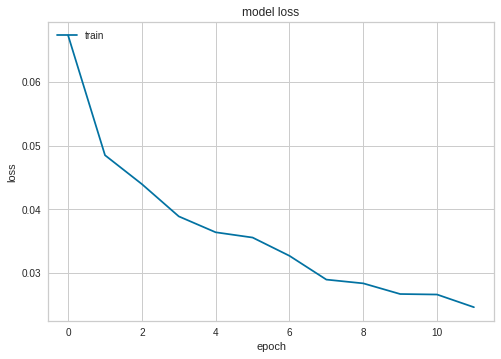

In [73]:
# "Loss"
plt.plot(nn_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [74]:
# ► For more info: https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py

# ► function inversed

def predict_sequence_full(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    #return prediction_seqs
    return [scaler.inverse_transform(np.array(i).reshape(1, -1))[0].tolist() for i in prediction_seqs]

In [75]:
# ► Function to print data windows

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')

Support functions defined


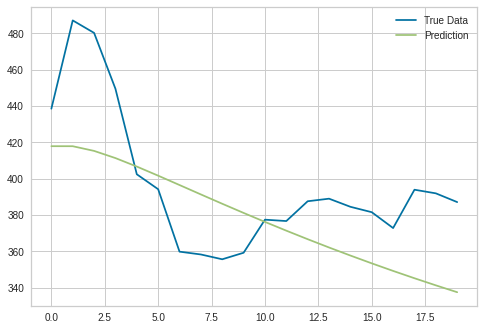

The Mean Absolute Error is: 30.474978698730467


In [78]:
# ► Calling functions to predict and plot windows

predsl = predict_sequence_full(nn_model, LSTM_test_inputs, 20, 20)
LSTM_test_outputs_inversed = scaler.inverse_transform(np.array(LSTM_test_outputs).reshape(1, -1))[0]
plot_results_multiple(predsl, LSTM_test_outputs_inversed, 20)
MAE = mean_absolute_error(LSTM_test_outputs_inversed, list(flatten(predsl)))
print('The Mean Absolute Error is: {}'.format(MAE))

### GRU (Gated Recurrent Units)

In [79]:
GRU_train_inputs = LSTM_train_inputs
GRU_train_outputs = LSTM_train_outputs
GRU_test_inputs = LSTM_test_inputs
GRU_test_outputs = LSTM_test_outputs

In [80]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=20, return_sequences=True, input_shape=(GRU_train_inputs.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=60, return_sequences=True, input_shape=(GRU_train_inputs.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=120, return_sequences=True, input_shape=(GRU_train_inputs.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=20, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(GRU_train_inputs, GRU_train_outputs,epochs=8,batch_size=80)

Epoch 1/8
23/23 [==============================] - 2s 73ms/step - loss: 0.1495
Epoch 2/8
23/23 [==============================] - 2s 72ms/step - loss: 0.0238
Epoch 3/8
23/23 [==============================] - 2s 70ms/step - loss: 0.0124
Epoch 4/8
23/23 [==============================] - 2s 70ms/step - loss: 0.0113
Epoch 5/8
23/23 [==============================] - 2s 69ms/step - loss: 0.0105
Epoch 6/8
23/23 [==============================] - 2s 69ms/step - loss: 0.0101
Epoch 7/8
23/23 [==============================] - 2s 69ms/step - loss: 0.0091
Epoch 8/8
23/23 [==============================] - 2s 68ms/step - loss: 0.0085


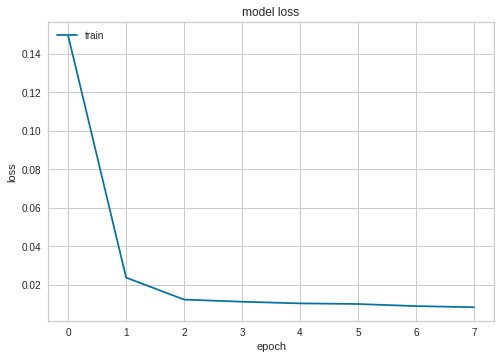

In [81]:
plt.plot(regressorGRU.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

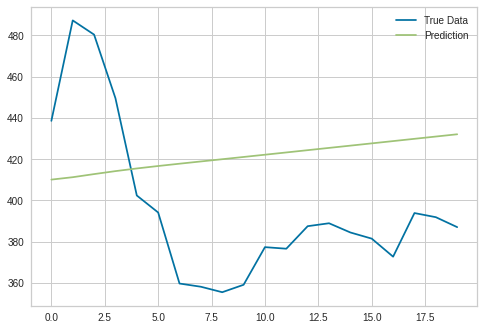

The Mean Absolute Error is: 45.84284808349609


In [82]:
# ► Calling functions to predict and plot windows

predsg = predict_sequence_full(regressorGRU, GRU_test_inputs, 20, 20)
GRU_test_inversed = scaler.inverse_transform(np.array(GRU_test_outputs).reshape(1, -1))[0]
plot_results_multiple(predsg, GRU_test_inversed, 20)
MAE = mean_absolute_error(GRU_test_inversed, list(flatten(predsg)))
print('The Mean Absolute Error is: {}'.format(MAE))

# Comparing

In [ ]:
my_coin_forecast_cp[-30:-20]

,high,prophet_high,arima_high,pycaret_high
2020-08-13,432.90,385.002730,389.678566,293.1198
2020-08-14,444.58,385.302292,388.074515,303.7527
2020-08-15,441.75,389.168145,387.779858,295.6777
2020-08-16,436.27,391.803274,385.715833,293.5974
2020-08-17,442.73,394.810959,384.986199,293.0792
2020-08-18,432.58,396.287933,386.918528,295.7888
2020-08-19,427.02,397.726687,390.512720,291.6421
2020-08-20,418.73,397.730465,390.291815,293.1198
2020-08-21,418.64,396.882797,391.165455,303.7527
2020-08-22,396.47,399.592812,389.847775,295.6777


In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=my_coin_forecast_cp.index[-40:], y=my_coin_forecast_cp['high'][-40:],
                    mode='lines',
                    name='Open'))
fig.add_trace(go.Scatter(x=my_coin_forecast_cp.index[-40:], y=my_coin_forecast_cp['prophet_high'][-40:],
                    mode='lines',
                    name='High'))
fig.add_trace(go.Scatter(x=my_coin_forecast_cp.index[-40:], y=my_coin_forecast_cp['arima_high'][-40:],
                    mode='lines',
                    name='Low'))
fig.add_trace(go.Scatter(x=my_coin_forecast_cp.index[-40:], y=my_coin_forecast_cp['pycaret_high'][-40:],
                    mode='lines',
                    name='Close'))

fig.update_layout(title="Coin behavior forecast vs actuals, price in USD")

fig.show()

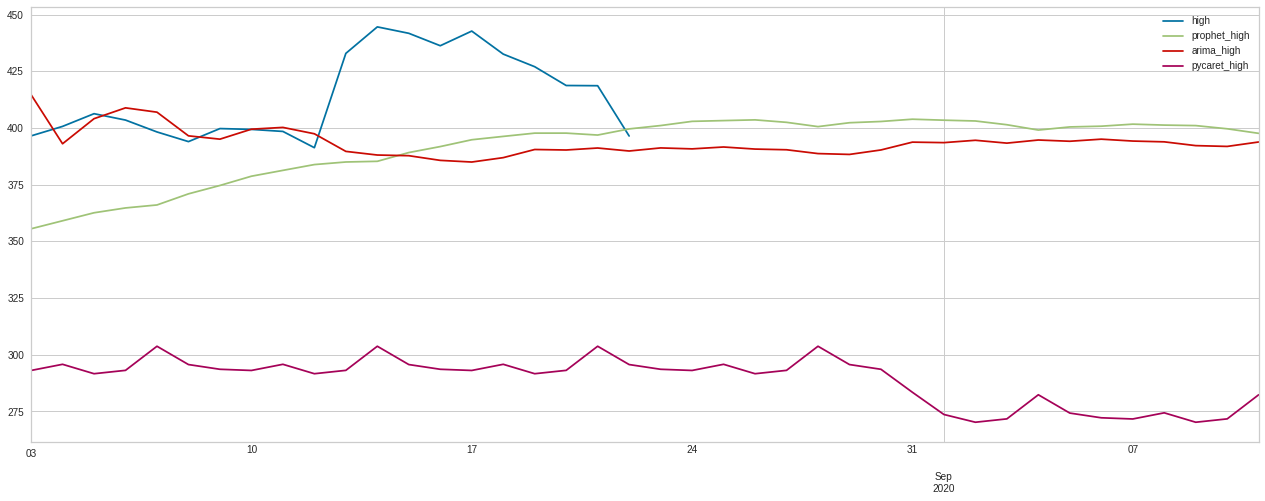

In [ ]:
_ = my_coin_forecast_cp[['high','prophet_high','arima_high','pycaret_high']][-40:].plot(figsize=(22, 8))

In [ ]:
# ► In the last step to compare models, not before cause there are issues with sklearn versions for pmdarima and pycaret 
from sklearn.metrics import mean_squared_error as mse
print('10 days mse arima: ',mse(my_coin_forecast_cp.high[-30:-20],my_coin_forecast_cp.arima_high[-30:-20]))
print('10 days mse prophet: ',mse(my_coin_forecast_cp.high[-30:-20],my_coin_forecast_cp.prophet_high[-30:-20]))
print('10 days mse pycaret: ',mse(my_coin_forecast_cp.high[-30:-20],my_coin_forecast_cp.pycaret_high[-30:-20]))

10 days mse arima:  1888.8995141742755
10 days mse prophet:  1594.5691387289044
10 days mse pycaret:  17963.389228648997


 
*   All models can be even tuned to get better-forecasted results.
*   The last 10 days are omitted to train models.
*   Still remains LSTM experimentation.

